# 3. Train the U-Net segmentation model

Our goal is to train a U-Net model to segment building footprints from drone imagery. We will use [`fastai`](https://docs.fast.ai/) built on top of [`PyTorch`](https://pytorch.org/docs/stable/index.html) to train our model as our deep learning framework.

Using the [Data Block API](https://docs.fast.ai/data.block.html) we will create a [`DataBunch`](https://docs.fast.ai/basic_data.html#DataBunch) object that will contain our training and validation data. We will use the [`ImageDataBunch.from_folder`](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder) method to create our `DataBunch` object. This method expects our data to be in the following format:


In [1]:
import matplotlib.pyplot as plt

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILBase, PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

c:\Users\HarrisonK\AppData\Local\miniforge3\envs\geo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TILE_SIZE = 256
ZOOM_LEVEL = 19

path = Path('./data')
for file in path.iterdir():
    print(file)

data\images
data\masks
data\polygons
data\raw-inputs


In [3]:
# Get the path to the images and masks
path_images = path/'images'/f's{TILE_SIZE}_z{ZOOM_LEVEL}'
path_masks = path/'masks'/f's{TILE_SIZE}_z{ZOOM_LEVEL}'

# Get filenames for the training images and masks
file_names = get_image_files(path_images/'train')
label_names = get_image_files(path_masks/'train')

# Get filenames for the validation images and masks
file_names_validation = get_image_files(path_images/'validation')
label_names_validation = get_image_files(path_masks/'validation')

print('Training images:', len(file_names))
print('Training masks:', len(label_names))

Training images: 814
Training masks: 814


In [4]:
def get_image_mask(image_path: Path) -> Path:
    ''' Gets the path of the mask corresponding to the image path
    Args:
        image_path (Path): Path to the image

    Returns:
        Path: Path to the mask
    '''
    return path_masks/image_path.parent.name/f'{image_path.stem}_mask.png'

In [5]:
print('Example image: ', file_names[0])
print('Example mask: ', get_image_mask(file_names[0]))

Example image:  data\images\s256_z19\train\319377_270486_19.png
Example mask:  data\masks\s256_z19\train\319377_270486_19_mask.png


As the `PILMask.create` method opens the mask by default in `L` mode or grayscale and we want to open it in `RGB` mode. We will subclass `PILMask` directly with a new class `PILMaskRGB` and override the open method to open the mask in `RGB` mode.

In [6]:
class PILMaskRBG(PILBase):
    "A Pillow `Image` Mask that can show itself and converts to `TensorMask`"
    _open_args,_show_args = {'mode':'RGB'},{'alpha':0.5, 'cmap':'tab20'}

<AxesSubplot:title={'center':'Image with mask'}>

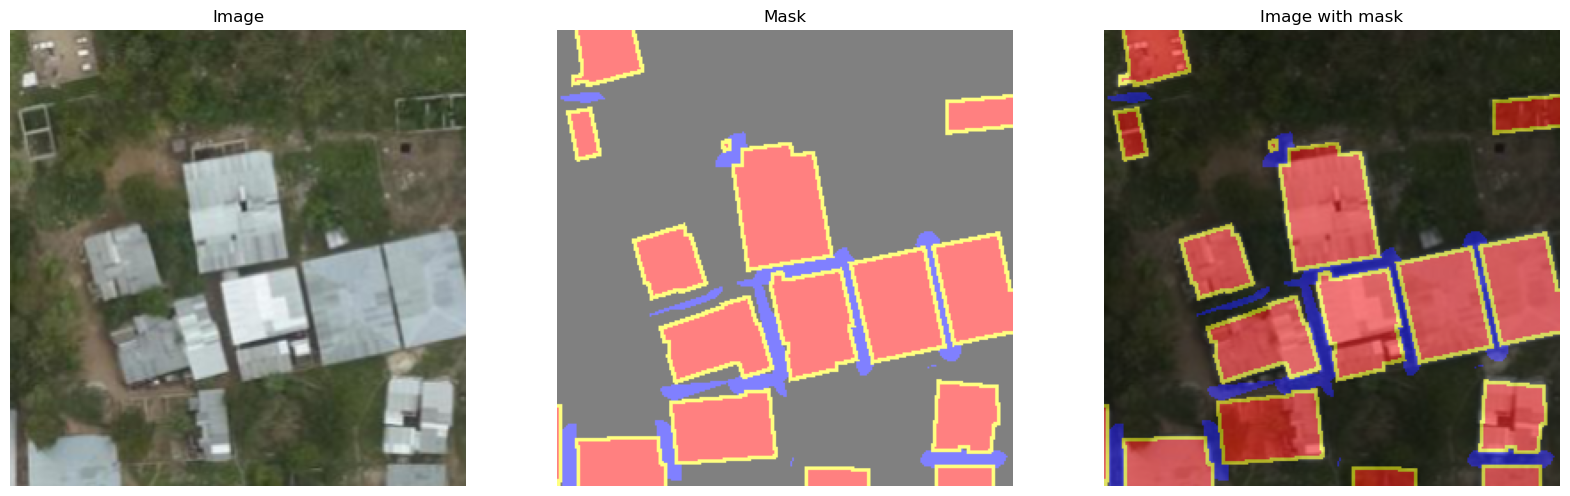

In [7]:
# Test opening an image and its mask
image_filename = file_names[15]
image = PILImage.create(image_filename)

mask = mask = PILMaskRBG.create(get_image_mask(image_filename))

# Show the image and mask side by side and overlay the mask on the image
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].set_title('Image')
image.show(ax=ax[0])

ax[1].set_title('Mask')
mask.show(ax=ax[1])

ax[2].set_title('Image with mask')
image.show(ax=ax[2])
mask.show(ax=ax[2], alpha=0.5)